In [1]:
import numpy as np
import pandas as pd
import rasterio
from affine import Affine
import matplotlib.pyplot as plt
import matplotlib.image as mping
import matplotlib.colors as colors

In [2]:
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas.tools import sjoin
import pandas as pd
from shapely import wkt
from fiona.crs import from_epsg
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona
from shapely.geometry import shape,mapping, Point, Polygon, MultiPolygon

### https://automating-gis-processes.github.io/CSC18/index.html
### https://rasterio.readthedocs.io/en/latest/quickstart.html
### http://darribas.org/gds15/content/labs/lab_03.html

### Each monthly tarball contains 2 files, the first one is the average DNB radiance, the second contains the number of cloud-free observations used in the average.

## The "vcmsl" version, that includes the stray-light corrected data, will have more data coverage toward the poles, but will be of reduced quality.

In [5]:
file_in = 'SVDNB/2017/SVDNB_npp_20171201-20171231_75N060E_vcmcfg_v10_c201801021747/SVDNB_npp_20171201-20171231_75N060E_vcmcfg_v10_c201801021747.avg_rade9h.tif'

In [6]:
dataset = rasterio.open(file_in)
dataset.count

1

In [7]:
dataset.bounds

BoundingBox(left=59.99791666665, bottom=0.0020827333499937595, right=179.99791762665, top=75.00208333335)

In [8]:
for k in dataset.meta:
    print(k,dataset.meta[k])

driver GTiff
dtype float32
nodata None
width 28800
height 18000
count 1
crs EPSG:4326
transform | 0.00, 0.00, 60.00|
| 0.00,-0.00, 75.00|
| 0.00, 0.00, 1.00|


## the map covers from the left -180 to the right -60 and from bottom 0 to top 75
### I Think they are latitude and longitude

In [9]:
dataset.height, dataset.width

(18000, 28800)

In [10]:
dataset.crs

CRS.from_epsg(4326)

## Corordinate refernce system 
https://epsg.io/ 
####  4326 is latitude , longitude..Good!

In [11]:
band1 = dataset.read(1)
band1.shape

(18000, 28800)

In [12]:
band1[0:10,0:10]

array([[0.85, 0.86, 0.89, 0.89, 0.86, 0.89, 0.9 , 0.9 , 0.87, 0.87],
       [0.83, 0.87, 0.87, 0.86, 0.87, 0.86, 0.87, 0.88, 0.88, 0.85],
       [0.87, 0.88, 0.89, 0.85, 0.86, 0.88, 0.89, 0.87, 0.89, 0.84],
       [0.87, 0.89, 0.89, 0.88, 0.89, 0.85, 0.89, 0.89, 0.9 , 0.86],
       [0.89, 0.91, 0.88, 0.87, 0.87, 0.87, 0.91, 0.93, 0.89, 0.91],
       [0.9 , 0.93, 0.87, 0.86, 0.86, 0.89, 0.9 , 0.93, 0.93, 0.86],
       [0.83, 0.81, 0.83, 0.83, 0.86, 0.87, 0.92, 0.93, 0.92, 0.89],
       [0.86, 0.85, 0.86, 0.87, 0.9 , 0.9 , 0.87, 0.91, 0.92, 0.93],
       [0.88, 0.87, 0.88, 0.89, 0.89, 0.87, 0.87, 0.88, 0.92, 0.89],
       [0.9 , 0.85, 0.89, 0.9 , 0.87, 0.86, 0.81, 0.9 , 0.89, 0.88]],
      dtype=float32)

### A dataset’s transform is an affine transformation matrix that maps pixel locations in (row, col) coordinates to (x, y) 

In [13]:
dataset.transform

Affine(0.0041666667, 0.0, 59.99791666665,
       0.0, -0.0041666667, 75.00208333335)

In [14]:
dataset.transform.a, dataset.transform.e, dataset.transform.c, dataset.transform.f

(0.0041666667, -0.0041666667, 59.99791666665, 75.00208333335)

# Convert to Corodinate

In [15]:
dataset.transform * (0, 0) ,dataset.transform * (dataset.width, dataset.height)

((59.99791666665, 75.00208333335), (179.99791762665, 0.0020827333499937595))

In [16]:
dataset.transform * (0,9) , dataset.transform * (0,dataset.height) ,dataset.transform * (dataset.width, 0) 

((59.99791666665, 74.96458333305),
 (59.99791666665, 0.0020827333499937595),
 (179.99791762665, 75.00208333335))

In [17]:
(dataset.transform * (0, 0))[0]

59.99791666665

### each row corrsponds to a longitude
### each column corresponds to a latitude


In [18]:
column_list = []
longitude_list = []
latitude_list= []
for i in range(dataset.height):
    l1 =(dataset.transform * (0,i))[1]

    if l1<=28 and l1>= 8:
        column_list.append(i)
        latitude_list.append(l1)
row_list = []      
for j in range(dataset.height):
    l2 =(dataset.transform * (j,0))[0]
    if l2 <=88 and l2 >=76:
        row_list.append(j)
        longitude_list.append(l2)
                
longitude_list = np.array(longitude_list)
latitude_list = np.array(latitude_list)
print(len(column_list),len(row_list), len(longitude_list),len(latitude_list))

4800 2880 2880 4800


In [55]:
# row_list =  row_list[1000:1200]
# column_list = column_list[100:140]

# longitude_list=  longitude_list[1000:1200]
# latitude_list = latitude_list[100:140]

In [19]:
light = band1[row_list,:][:,column_list]
df = np.transpose([np.repeat(longitude_list, len(latitude_list)), 
              np.tile(latitude_list, len(longitude_list)),light.flatten()])

3 perc entile 0.10000000149011612 97 percentie 0.30000001192092896


(array([2476088.,       0., 1186165., 2057989.,       0., 1575937.,
         609101.,       0.,  872762.,  283021.,  202934.,       0.,
         140303.,  163606.,       0.,   48742.,   64852.,       0.,
          23468.,   36033.,       0.,   14701.,   24382.,   10191.,
              0.,   17490.,    7634.,       0.,   13383.,    6050.,
              0.,   10749.,    4781.,       0.]),
 array([0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25,
        0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36,
        0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47,
        0.48, 0.49]),
 <a list of 34 Patch objects>)

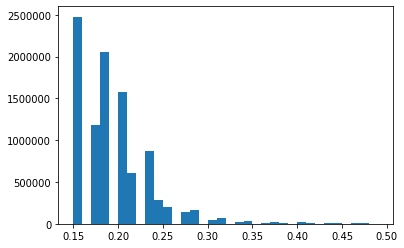

In [20]:
light_flatten = light.flatten()
l,u,c = np.quantile(light_flatten, [0.03,0.97,0.1])
print("3 perc entile {} 97 percentie {}".format(l,u))
plt.hist(light_flatten, bins=np.arange(0.15,0.50,0.01))

In [25]:
np.quantile(light_flatten, 0.5), np.quantile(light_flatten, [0.01,0.99])

(0.17000000178813934, array([0.09      , 0.61000001]))

In [26]:
np.mean(light_flatten), np.std(light_flatten),np.max(light_flatten), np.min(light_flatten)

(0.2500982, 10.224672, 12044.26, -0.51)

In [66]:
28800*4800

138240000

In [67]:
df.shape

(13824000, 3)

In [68]:
df = pd.DataFrame(df)
df.columns = ['longitude','latitude','NB']
df.to_pickle("data.pickle")

In [74]:
column_list = []
longitude_list = []
latitude_list= []
for i in range(dataset.height):
    l1 =(dataset.transform * (0,i))[1]

    if l1<=27 and l1>= 22:
        column_list.append(i)
        latitude_list.append(l1)
row_list = []      
for j in range(dataset.height):
    l2 =(dataset.transform * (j,0))[0]
    if l2 <=89 and l2 >=86:
        row_list.append(j)
        longitude_list.append(l2)
                
longitude_list = np.array(longitude_list)
latitude_list = np.array(latitude_list)
print(len(column_list),len(row_list), len(longitude_list),len(latitude_list))

light = band1[row_list,:][:,column_list]
df = np.transpose([np.repeat(longitude_list, len(latitude_list)), 
              np.tile(latitude_list, len(longitude_list)),light.flatten()])
print(df.shape)

df = pd.DataFrame(df)
df.columns = ['longitude','latitude','NB']
df.to_pickle("WB_alldata.pickle")

df = df[(df['NB']<u)&(df['NB']>l)]
df['NB'] = df['NB'].apply(lambda x: x if x>c else 0)
df.to_pickle("WB_filtereddata.pickle")

1200 720 720 1200
(864000, 3)


### multiply with transform to know coordinate

In [21]:
dataset.index(0,0)

(18000, 43200)

In [10]:
x, y = (dataset.bounds.right , dataset.bounds.top )
row, col = dataset.index(x, y)
print(x,y)
print(row,col)
band1[row-1, col-1]

-60.00208237334998 75.00208333335
0 28800


0.04

In [41]:
for k in dataset.meta:
    print(k,dataset.meta[k])

driver GTiff
dtype float32
nodata None
width 28800
height 18000
count 1
crs EPSG:4326
transform | 0.00, 0.00, 60.00|
| 0.00,-0.00, 75.00|
| 0.00, 0.00, 1.00|


In [40]:
gdf

,longitude,latitude,NB,geometry
0,80.168750,27.581250,0.25,POINT (80.16875 27.58125)
1,80.168750,27.577083,0.27,POINT (80.16875 27.57708)
2,80.168750,27.572916,0.30,POINT (80.16875 27.57292)
3,80.168750,27.568750,0.33,POINT (80.16875 27.56875)
4,80.168750,27.564583,0.30,POINT (80.16875 27.56458)
...,...,...,...,...
7995,80.997917,27.435416,0.35,POINT (80.99792 27.43542)
7996,80.997917,27.431250,0.34,POINT (80.99792 27.43125)
7997,80.997917,27.427083,0.28,POINT (80.99792 27.42708)
7998,80.997917,27.422916,0.28,POINT (80.99792 27.42292)


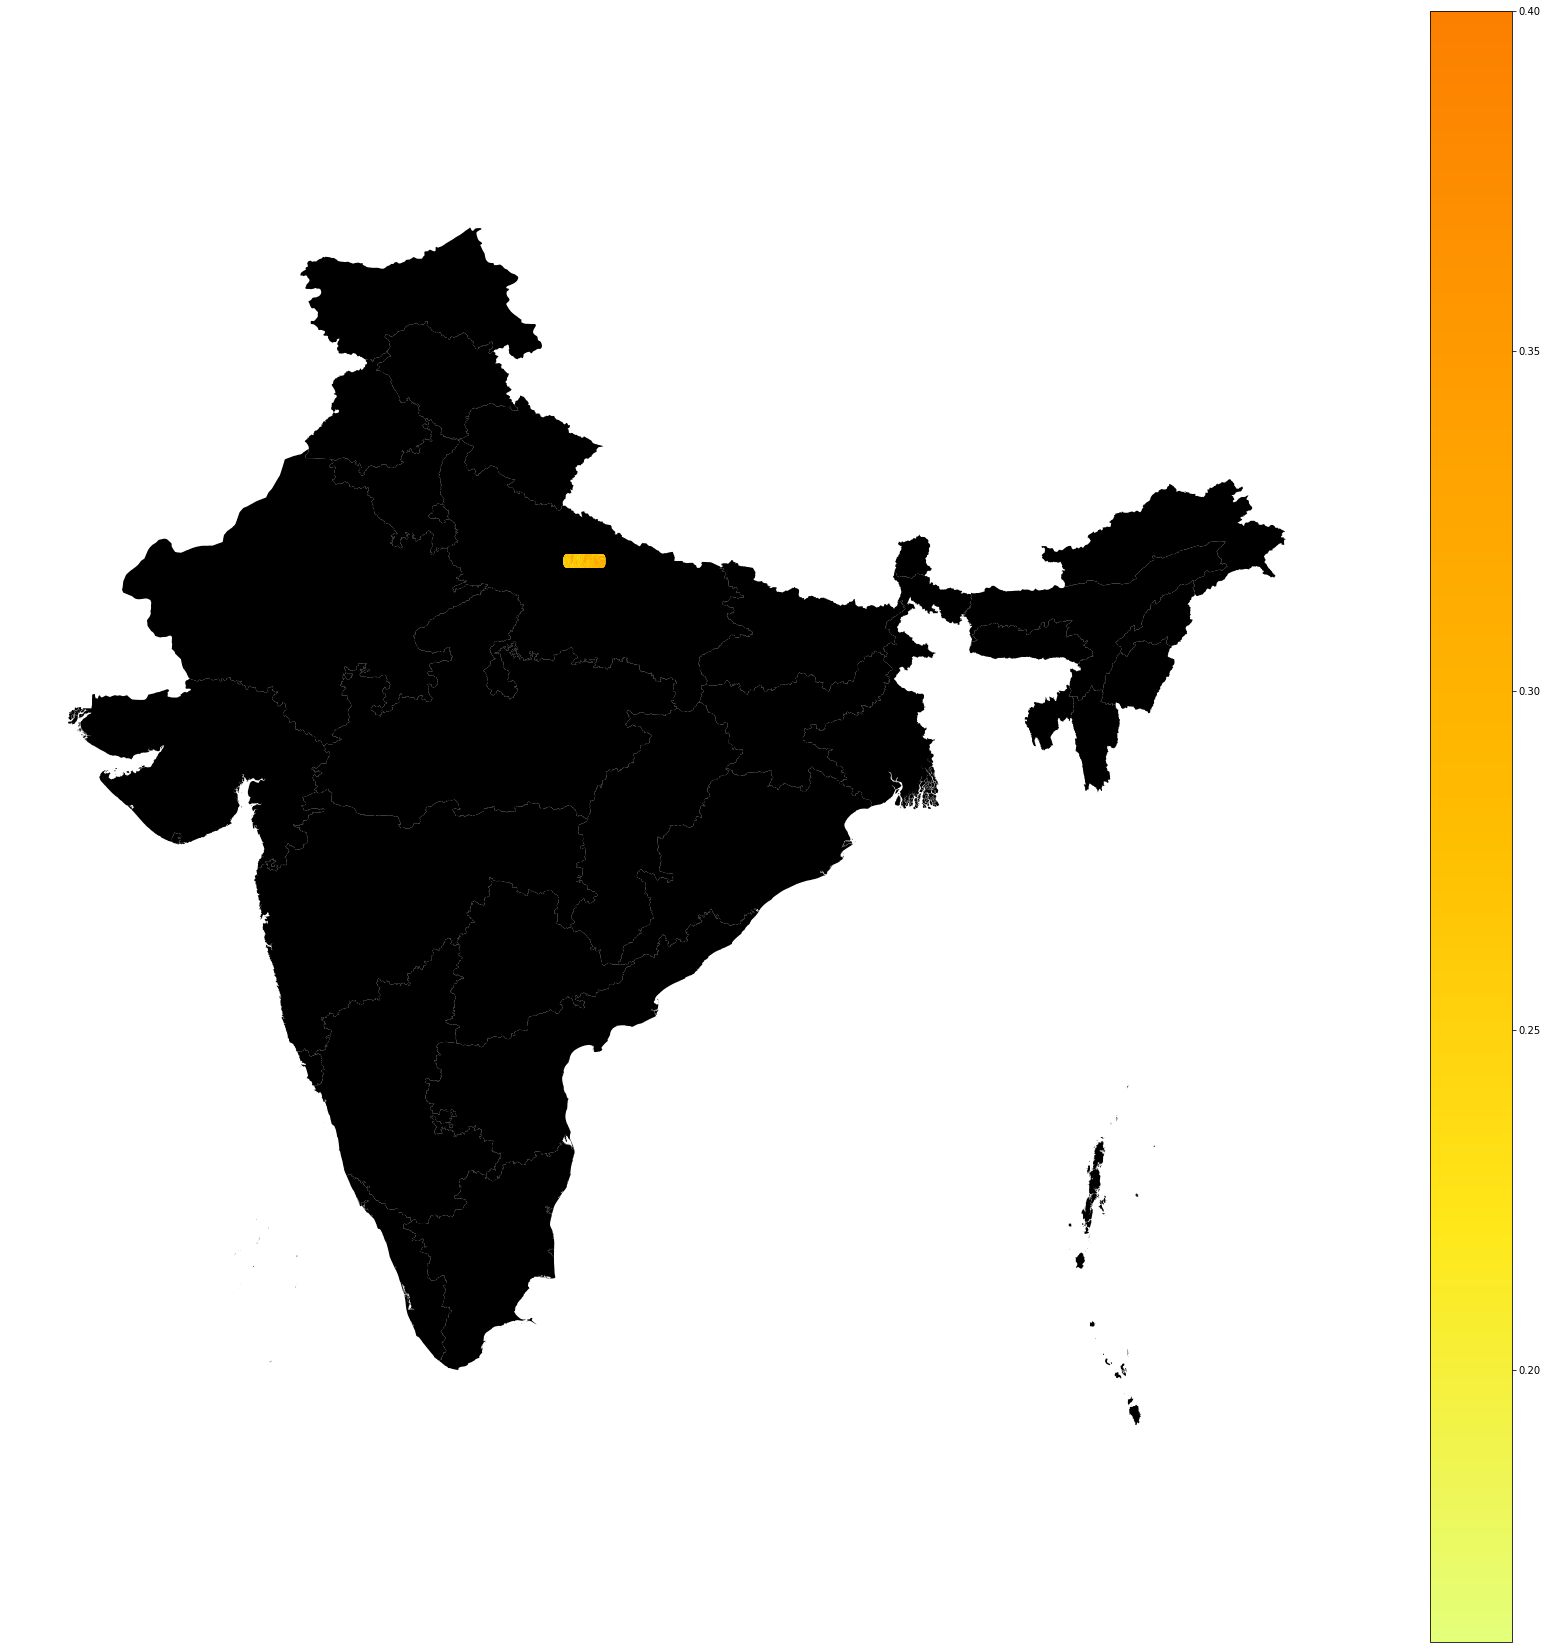

In [30]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.crs = "epsg:4326"
namp = gpd.read_file("IND_adm/IND_adm1.shp")

f, ax = plt.subplots(figsize=(30,30))
namp.plot(ax=ax,color= "black")

gdf.plot(ax=ax, column= "NB",legend=True,cmap = 'Wistia')
ax.set_axis_off()
lims = plt.axis('equal')
plt.show()

In [39]:
point =  points.loc[0,"geometry"]
ap= namp.loc[0,"geometry"]
up = namp.loc[33,"geometry"]
print("Point is in AP",point.within(shape(ap)))
print("Point is in UP",point.within(shape(up)))

Point is in AP False
Point is in UP True


In [ ]:
if isinstance(dataset.transform, Affine):
     transform = dataset.transform
else:
     transform = dataset.affine

N = dataset.width
M = dataset.height
dx = transform.a
dy = transform.e
minx = transform.c
maxy = transform.f

# Read the image data, flip upside down if necessary
data_in = dataset.read(1)
if dy < 0:
  dy = -dy
  data_in = np.flip(data_in, 0)

print('Data minimum, maximum = ', np.amin(data_in), np.amax(data_in))

# Generate X and Y grid locations
xdata = minx + dx/2 + dx*np.arange(N)
ydata = maxy - dy/2 - dy*np.arange(M-1,-1,-1)

# Scale the velocities by the log of the data.
d = np.log(np.clip(data_in, 1, 3000))
data_scale = (255*(d - np.amin(d))/np.ptp(d)).astype(np.uint8)

# Construct an RGB table using a log scale between 1 and 3000 m/year.
vel = np.exp(np.linspace(np.log(1), np.log(3000), num=256))
hue = np.arange(256)/255.0
sat = np.clip(1./3 + vel/187.5, 0, 1)
value = np.zeros(256) + 0.75
hsv = np.stack((hue, sat, value), axis=1)
rgb = colors.hsv_to_rgb(hsv)
# Be sure the first color (the background) is white
rgb[0,:] = 1
cmap = colors.ListedColormap(rgb, name='velocity')

extent = [xdata[0], xdata[-1], ydata[0], ydata[-1]]
plt.figure(figsize=(8,8))
fig = plt.imshow(data_scale, extent=extent, origin='lower', cmap=cmap)
plt.title(file_in)
# Hide the axes and remove the space around them
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
tickval = [1, 10, 100, 1000, 3000]
t = np.log(tickval)
cb = plt.colorbar(fig, ticks=255*(t - t[0])/(t[-1] - t[0]), shrink=0.5)
cb.set_label('Velocity Magnitude (m/year)')
cb.ax.set_yticklabels(tickval)
plt.savefig("python_sample.png", dpi=300, bbox_inches='tight', pad_inches=0.5)
plt.show()

Data minimum, maximum =  -1.02 21473.26


In [11]:
file_in = 'SVDNB/SVDNB_npp_20191201-20191231_75N180W_vcmcfg_v10_c202001140900.cf_cvg.tif'

In [15]:
dataset = rasterio.open(file_in)
for k in dataset.meta:
    print(k,dataset.meta[k])
print("Bounds {}".format(dataset.bounds))

driver GTiff
dtype uint16
nodata None
width 28800
height 18000
count 1
crs EPSG:4326
transform | 0.00, 0.00,-180.00|
| 0.00,-0.00, 75.00|
| 0.00, 0.00, 1.00|
Bounds BoundingBox(left=-180.00208333335, bottom=0.0020827333499937595, right=-60.00208237334998, top=75.00208333335)


In [17]:
band1 = dataset.read(1)
print(band1.shape)
band1[0:10,0:10]

(18000, 28800)


array([[42, 41, 41, 42, 43, 43, 43, 43, 42, 42],
       [42, 41, 42, 42, 43, 43, 43, 43, 42, 42],
       [41, 41, 42, 42, 41, 40, 41, 41, 41, 42],
       [41, 41, 41, 41, 40, 40, 40, 40, 40, 40],
       [41, 41, 40, 40, 40, 40, 40, 40, 40, 40],
       [40, 40, 40, 40, 41, 41, 41, 41, 41, 41],
       [41, 41, 41, 41, 41, 41, 41, 41, 41, 40],
       [41, 41, 41, 41, 41, 41, 41, 41, 41, 40],
       [41, 41, 41, 41, 41, 41, 41, 41, 41, 40],
       [40, 40, 41, 41, 41, 41, 41, 41, 41, 41]], dtype=uint16)

### geopandas:  https://geopandas.org/gallery/index.html

In [27]:
import argparse
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely import wkt
from fiona.crs import from_epsg
import numpy as np
import fiona
from shapely.geometry import shape,mapping, Point, Polygon, MultiPolygon
namp = gpd.read_file("maps-master/Districts/Census_2011/2011_Dist.shp")

In [28]:
df = pd.read_stata('VIIRS_lights_monthly_2012_2017_DistrictLevel_IND_share_new.dta')
df_1712 = df[(df.State_name=='West Bengal')&(df.year==2017)&(df.month==12)][['dist_name','ntl_s_n_cl','ntl_s_n_cl_a','ntl_s_n','ntl_s_n_a']]
df_1711 = df[(df.State_name=='West Bengal')&(df.year==2017)&(df.month==11)][['dist_name','ntl_s_n_cl','ntl_s_n_cl_a','ntl_s_n','ntl_s_n_a']]

In [29]:
df_1712['dist_name'] = df_1712.dist_name.apply(lambda x:'North 24 Parganas'  if x=="North Twenty Four Parganas" else "Pashchim Medinipur" 
                        if x=="Paschim Medinipur" else "South 24 Parganas"   if x== "South Twenty Four Parganas" else x)

df_1711['dist_name'] = df_1711.dist_name.apply(lambda x:'North 24 Parganas'  if x=="North Twenty Four Parganas" else "Pashchim Medinipur" 
                        if x=="Paschim Medinipur" else "South 24 Parganas"   if x== "South Twenty Four Parganas" else x)

In [30]:
wb_17_11 = pd.read_pickle("2017/11/WB_table.pickle")
wb_17_11 = wb_17_11.merge(namp,on="DISTRICT",how="left")
wb_17_11 = gpd.GeoDataFrame(wb_17_11)



In [31]:
wb_17_12 = pd.read_pickle("2017/12/WB_table.pickle")
wb_17_12 = wb_17_12.merge(namp,on="DISTRICT",how="left")
wb_17_12 = gpd.GeoDataFrame(wb_17_12)


In [32]:
wb_19_12 = pd.read_pickle("2019/12/WB_table.pickle")
wb_19_12 = wb_19_12.merge(namp,on="DISTRICT",how="left")
wb_19_12 = gpd.GeoDataFrame(wb_19_12)

In [33]:
wb_17_12 = wb_17_12.merge(df_1712,left_on='DISTRICT',right_on='dist_name',how='outer')
wb_17_11 = wb_17_11.merge(df_1711,left_on='DISTRICT',right_on='dist_name',how='outer')

In [56]:
wb_17_11[['DISTRICT', 'count', 'sum','ntl_s_n_cl',
       'ntl_s_n_cl_a', 'ntl_s_n', 'ntl_s_n_a']]

,DISTRICT,count,sum,ntl_s_n_cl,ntl_s_n_cl_a,ntl_s_n,ntl_s_n_a
0,Bankura,35276,12609.210008,13067.187732,2.171355,33813.639946,5.618763
1,Barddhaman,35760,14216.109942,88476.985320,14.485463,107846.609917,17.656662
2,Birbhum,23212,9522.889949,20441.868782,5.177285,35533.799985,8.999598
3,Dakshin Dinajpur,11196,3896.640001,2592.748898,1.333564,9922.119989,5.103381
4,Darjiling,16712,6496.679991,7178.980324,2.547500,13930.029999,4.943146
5,Haora,7317,2895.639988,23885.063662,18.952938,26268.050001,20.843853
6,Hugli,15941,6344.359974,18841.779351,6.887932,27459.030010,10.038115
7,Jalpaiguri,31459,11261.230039,9830.441825,1.772119,26829.209961,4.836462
8,Koch Bihar,17462,5831.940035,4403.637257,1.485290,14626.979984,4.933492
9,Kolkata,465,173.270000,41046.870036,244.290863,41046.870036,244.290863


In [34]:
op = wb_17_12[['DISTRICT', 'count', 'sum']]
op

,DISTRICT,count,sum
0,Bankura,35276,6071.560019
1,Barddhaman,35760,7280.469993
2,Birbhum,23212,5048.799990
3,Dakshin Dinajpur,11196,1797.890002
4,Darjiling,16712,2964.000004
5,Haora,7317,1458.329999
6,Hugli,15941,3026.100001
7,Jalpaiguri,31459,5536.130006
8,Koch Bihar,17462,2731.250009
9,Kolkata,465,77.390000


In [35]:
op.to_csv("example.csv",index= False)

In [25]:
wb_17_12[['DISTRICT', 'count', 'sum', 'mean', 'std']].merge(df_1712,left_on='DISTRICT',right_on='dist_name',
                                                            how='outer')

,DISTRICT,count,sum,mean,std,dist_name,ntl_s_n_cl,ntl_s_n_cl_a,ntl_s_n,ntl_s_n_a
0,Bankura,35276,6071.560019,0.172116,0.039458,Bankura,12009.769401,1.995646,28173.109972,4.681485
1,Barddhaman,35760,7280.469993,0.203593,0.034120,Barddhaman,78723.152256,12.888565,95416.239822,15.621559
2,Birbhum,23212,5048.799990,0.217508,0.065866,Birbhum,20091.181355,5.088467,33187.279984,8.405298
3,Dakshin Dinajpur,11196,1797.890002,0.160583,0.037994,Dakshin Dinajpur,2614.361971,1.344681,9128.779987,4.695331
4,Darjiling,16712,2964.000004,0.177358,0.051500,Darjiling,7338.972621,2.604274,12554.239995,4.454939
5,Haora,7317,1458.329999,0.199307,0.035566,Haora,24125.717010,19.143898,26252.209971,20.831284
6,Hugli,15941,3026.100001,0.189831,0.041263,Hugli,18594.335025,6.797475,26076.889991,9.532850
7,Jalpaiguri,31459,5536.130006,0.175979,0.279997,Jalpaiguri,10438.944092,1.881813,25451.149976,4.588041
8,Koch Bihar,17462,2731.250009,0.156411,0.069273,Koch Bihar,4603.915358,1.552841,13101.089986,4.418828
9,Kolkata,465,77.390000,0.166430,0.033324,Kolkata,40524.159951,241.179947,40524.159951,241.179947


In [9]:
wb_17_12.DISTRICT.unique()

array(['Bankura', 'Barddhaman', 'Birbhum', 'Dakshin Dinajpur',
       'Darjiling', 'Haora', 'Hugli', 'Jalpaiguri', 'Koch Bihar',
       'Kolkata', 'Maldah', 'Murshidabad', 'Nadia', 'North 24 Parganas',
       'Pashchim Medinipur', 'Purba Medinipur', 'Puruliya',
       'South 24 Parganas', 'Uttar Dinajpur'], dtype=object)

In [10]:
df_1712.dist_name.unique()

array(['Darjiling', 'Jalpaiguri', 'Koch Bihar', 'Uttar Dinajpur',
       'Dakshin Dinajpur', 'Maldah', 'Murshidabad', 'Birbhum',
       'Barddhaman', 'Nadia', 'North Twenty Four Parganas', 'Hugli',
       'Bankura', 'Puruliya', 'Haora', 'Kolkata',
       'South Twenty Four Parganas', 'Paschim Medinipur',
       'Purba Medinipur'], dtype=object)

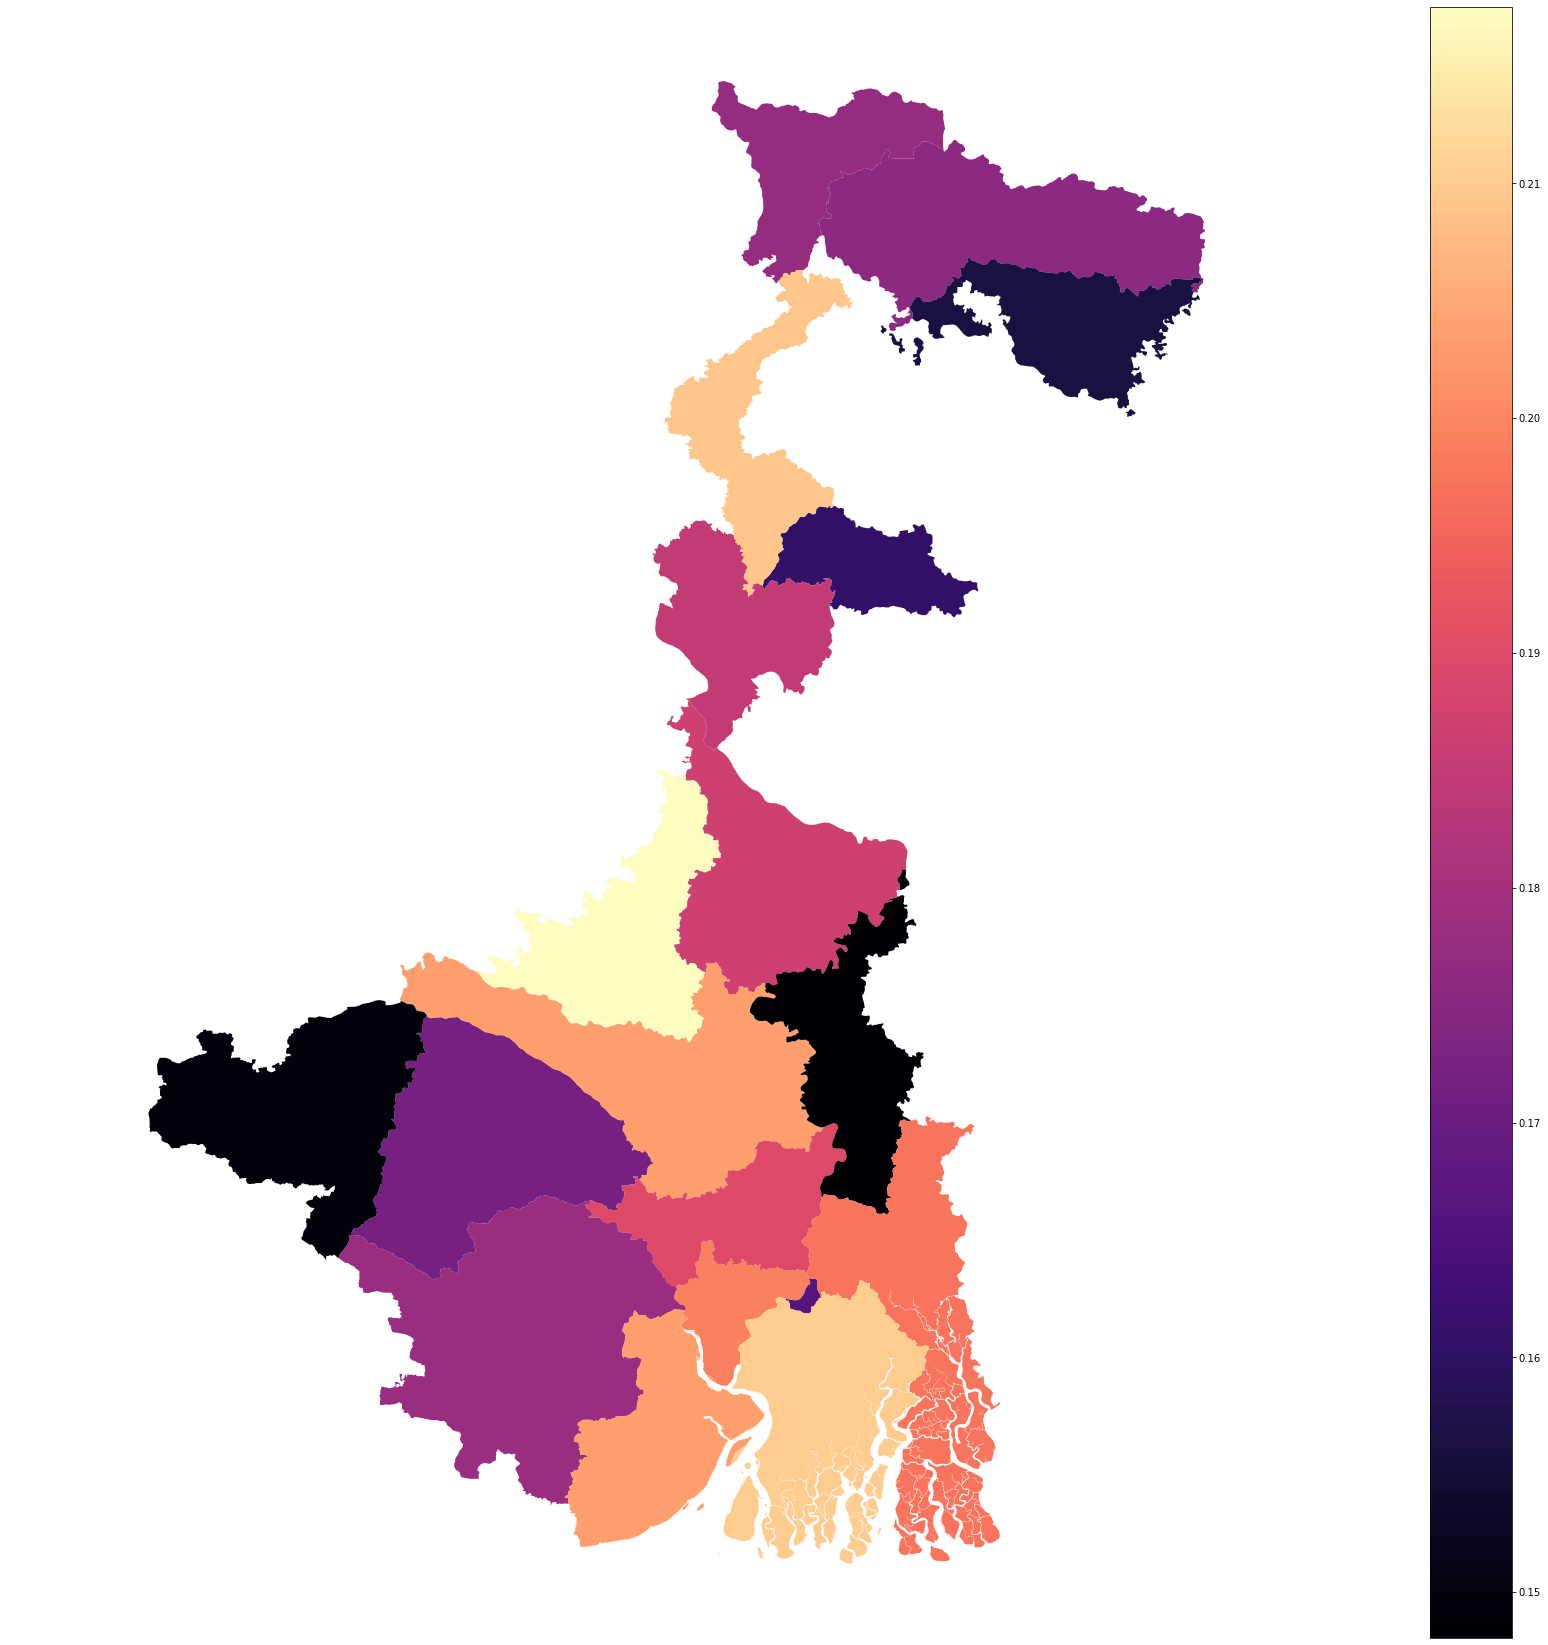

In [36]:
f, ax = plt.subplots(figsize=(30,30))
wb_17_12.plot(ax=ax,column="mean",legend=True,cmap = 'magma')
#gdf.plot(ax=ax, column= "NB",legend=True,cmap = 'Wistia')
ax.set_axis_off()
lims = plt.axis('equal')
plt.show()


In [13]:
wb_17_12.columns

Index(['DISTRICT', 'count', 'sum', 'mean', 'std', 'ST_NM', 'ST_CEN_CD',
       'DT_CEN_CD', 'censuscode', 'geometry', 'dist_name', 'ntl_s_n_cl',
       'ntl_s_n_cl_a', 'ntl_s_n', 'ntl_s_n_a'],
      dtype='object')

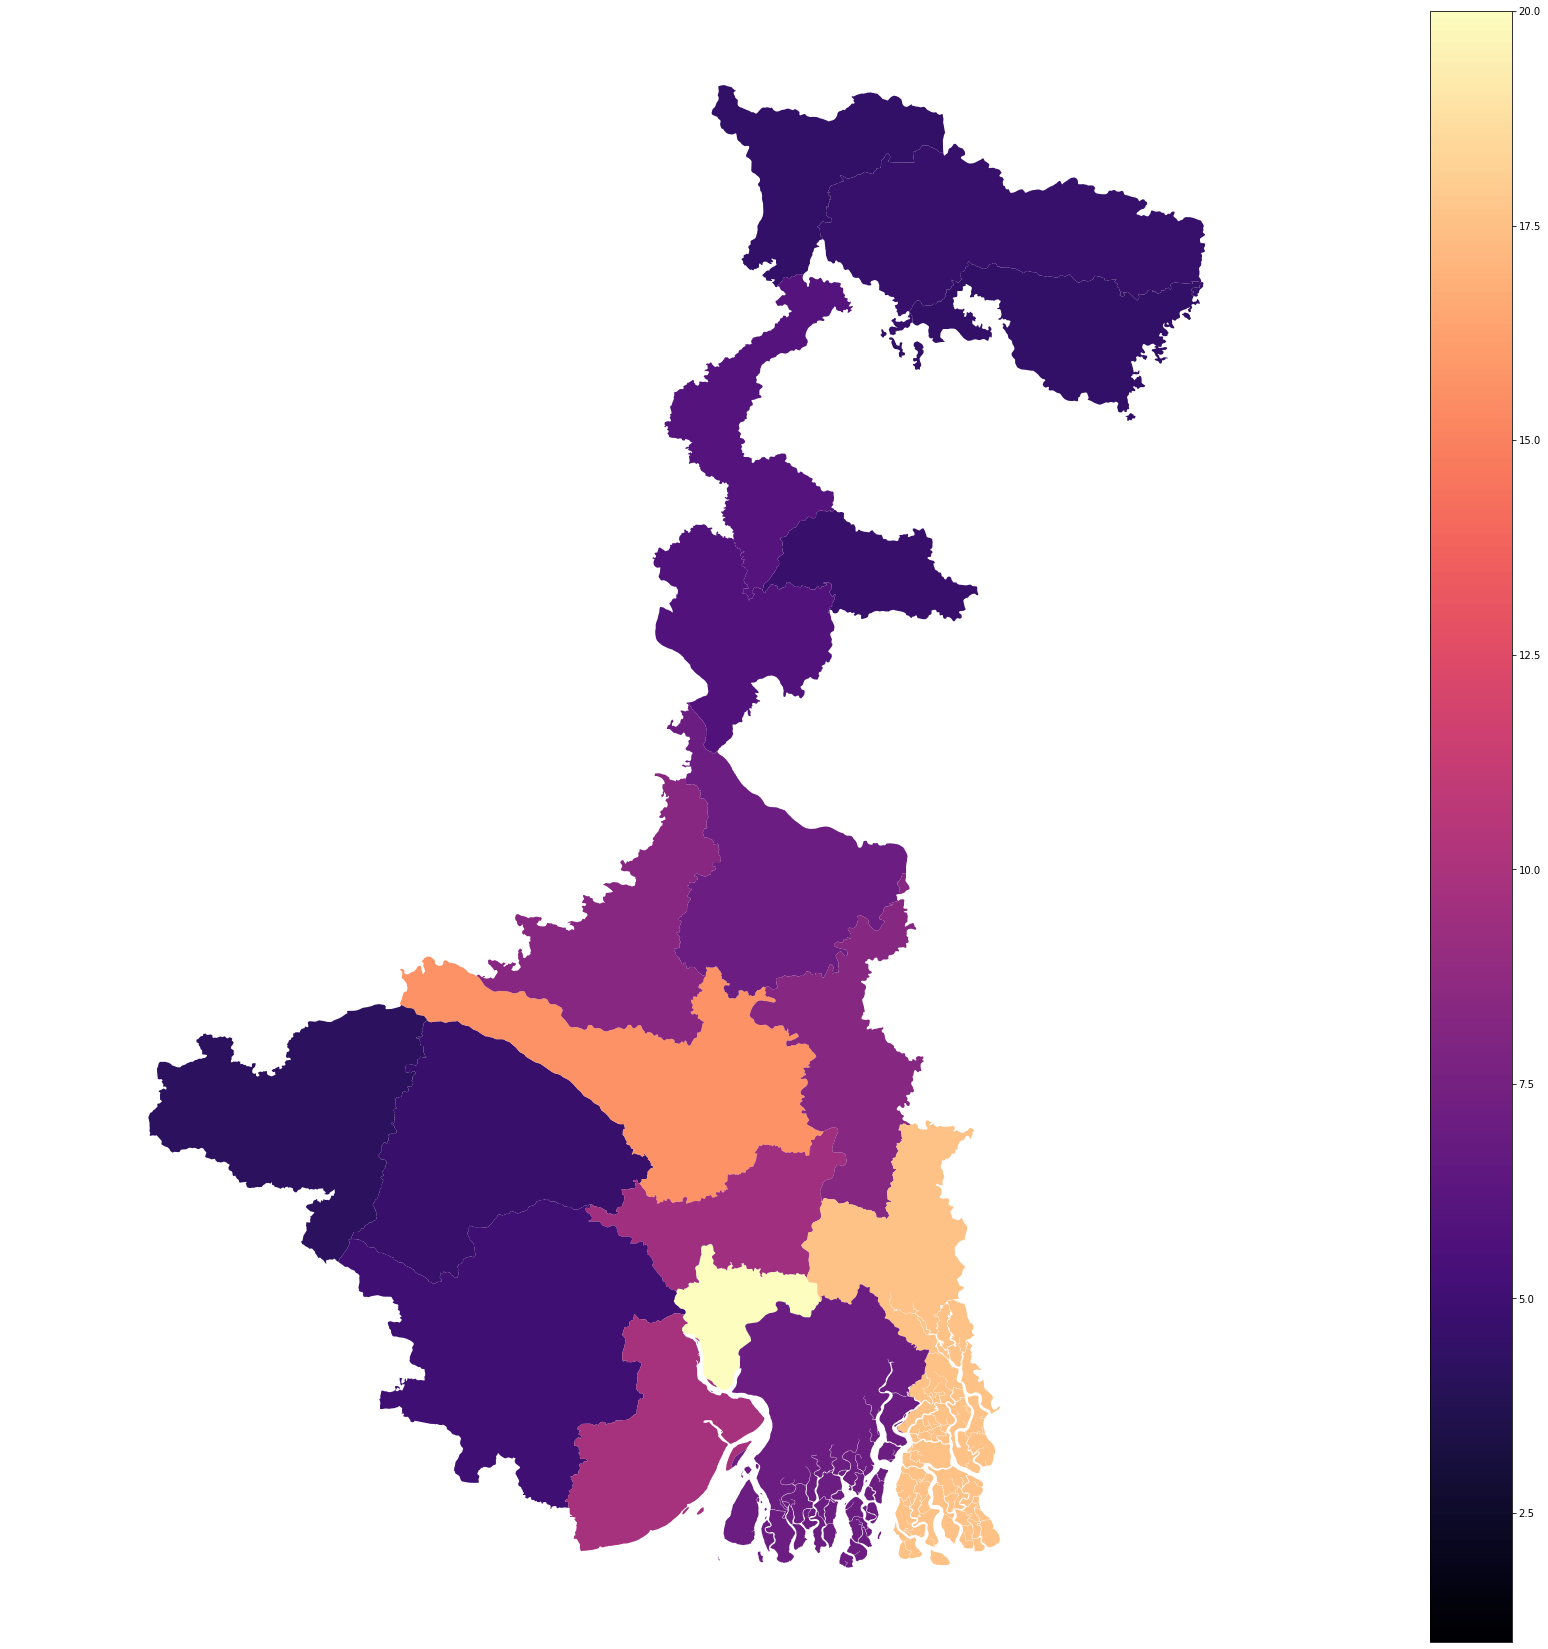

In [35]:
import matplotlib as mpl
f, ax = plt.subplots(figsize=(30,30))
wb_17_12.plot(ax=ax,column="ntl_s_n_a",legend=True,cmap = 'magma',
             norm=mpl.colors.Normalize(vmin=1, vmax=20))
#gdf.plot(ax=ax, column= "NB",legend=True,cmap = 'Wistia')
ax.set_axis_off()
lims = plt.axis('equal')
plt.show()

In [15]:
wb_17_12

,DISTRICT,count,sum,mean,std,ST_NM,ST_CEN_CD,DT_CEN_CD,censuscode,geometry,dist_name,ntl_s_n_cl,ntl_s_n_cl_a,ntl_s_n,ntl_s_n_a
0,Bankura,35276.0,6071.560019,0.172116,0.039458,West Bengal,19.0,13.0,339.0,"POLYGON ((87.71411 23.01057, 87.70942 23.01473...",Bankura,12009.769401,1.995646,28173.109972,4.681485
1,Barddhaman,35760.0,7280.469993,0.203593,0.034120,West Bengal,19.0,9.0,335.0,"POLYGON ((88.19771 23.76477, 88.19671 23.75623...",Barddhaman,78723.152256,12.888565,95416.239822,15.621559
2,Birbhum,23212.0,5048.799990,0.217508,0.065866,West Bengal,19.0,8.0,334.0,"POLYGON ((87.89239 24.56390, 87.89278 24.55224...",Birbhum,20091.181355,5.088467,33187.279984,8.405298
3,Dakshin Dinajpur,11196.0,1797.890002,0.160583,0.037994,West Bengal,19.0,5.0,331.0,"POLYGON ((88.18542 25.28589, 88.18690 25.28782...",Dakshin Dinajpur,2614.361971,1.344681,9128.779987,4.695331
4,Darjiling,16712.0,2964.000004,0.177358,0.051500,West Bengal,19.0,1.0,327.0,"POLYGON ((88.75870 27.14800, 88.75812 27.14525...",Darjiling,7338.972621,2.604274,12554.239995,4.454939
5,Haora,7317.0,1458.329999,0.199307,0.035566,West Bengal,19.0,15.0,341.0,"MULTIPOLYGON (((87.99513 22.77300, 87.99747 22...",Haora,24125.717010,19.143898,26252.209971,20.831284
6,Hugli,15941.0,3026.100001,0.189831,0.041263,West Bengal,19.0,12.0,338.0,"POLYGON ((88.41167 22.94525, 88.41310 22.93983...",Hugli,18594.335025,6.797475,26076.889991,9.532850
7,Jalpaiguri,31459.0,5536.130006,0.175979,0.279997,West Bengal,19.0,2.0,328.0,"POLYGON ((89.86232 26.70367, 89.86679 26.70024...",Jalpaiguri,10438.944092,1.881813,25451.149976,4.588041
8,Koch Bihar,17462.0,2731.250009,0.156411,0.069273,West Bengal,19.0,3.0,329.0,"MULTIPOLYGON (((89.02623 26.51818, 89.03012 26...",Koch Bihar,4603.915358,1.552841,13101.089986,4.418828
9,Kolkata,465.0,77.390000,0.166430,0.033324,West Bengal,19.0,16.0,342.0,"POLYGON ((88.41075 22.55997, 88.40914 22.55744...",Kolkata,40524.159951,241.179947,40524.159951,241.179947
